In [192]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import matplotlib.patheffects as path_effects
from scipy.spatial.distance import cosine
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from itertools import cycle
from sklearn.decomposition import PCA

plotting.style(12)

In [35]:
def mss(model1,model2,word,k=25):
    if not word in model1.vocab or not word in model2.vocab:
        return 0
    neighborhood1 = [w for w,c in model1.most_similar(word,topn=k)]
    neighborhood2 = [w for w,c in model2.most_similar(word,topn=k)]
    meta_neighborhood = list(set(neighborhood1)|set(neighborhood2))
    meta_neighborhood = [w for w in meta_neighborhood if w in model1.vocab and w in model2.vocab]
    vector1 = [model1.similarity(word,w) for w in meta_neighborhood]
    vector2 = [model2.similarity(word,w) for w in meta_neighborhood]
    return cosine(vector1,vector2)

Text(0.5, 0, 'Years (Two Year Sliding Window)')

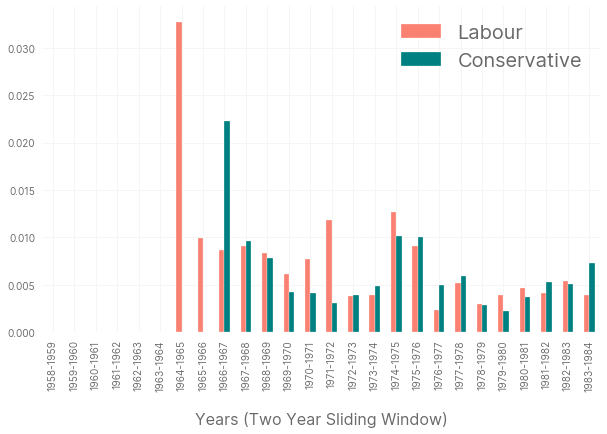

In [162]:
lf = sorted(gb("/home/ruben/Documents/GitHub/CrisisBureaucracy/results/w2v-models/*w24*"))
d = []
for c,m in enumerate(lf):
    if c == 0:
        continue 
    else:
        try:
            mc = KeyedVectors.load_word2vec_format(m,binary=True)
            mp = KeyedVectors.load_word2vec_format(lf[c-1],binary=True)
            d.append([m[-23:-14],mss(mp,mc,"bureaucracy_labour"),mss(mp,mc,"bureaucracy_conservative")])
        except:
            continue

d = pd.DataFrame(d,columns=["y","slab",'scon'])
d['y'] = [x[:9] for x in d['y']]
d.plot.bar(x='y',y=['slab','scon'],color=["salmon","teal"],figsize=(10,6))
plt.legend(["Labour","Conservative"],fontsize=20)
plt.xlabel('Years (Two Year Sliding Window)',labelpad=20)

In [116]:
def top_words_table(sorted_fns,word,iter_=1,topn=15):
    d = pd.DataFrame()

    for c in list(range(0,len(sorted_fns),iter_)):
        mc = KeyedVectors.load_word2vec_format(lf[c],binary=True)
        if word in set(mc.wv.vocab):
            ms = mc.wv.most_similar(word,topn=topn)
            ms = [x[0] for x in ms]
            d[lf[c][-23:-14]] = ms
        else:
            continue
    return d
df = top_words_table(lf,"bureaucracy_conservative",iter_=3,topn=25)
df.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/tables/w2v-topterms-bureaucracy_marked-iter3-topn25.csv',index=False)

In [163]:
def plot_similarity(word1,word2,lf):
    d = []
    for m in lf:
        mo = KeyedVectors.load_word2vec_format(m,binary=True)
        if word1 in mo.wv.vocab and word2 in mo.wv.vocab:
            d.append([m[-23:-14],mo.wv.similarity(word1,word2)])
    d = pd.DataFrame(d,columns=['1','2'])
    d.plot.bar(x='1',y='2',figsize=(10,5),legend=False)

(0.4, 1.0)

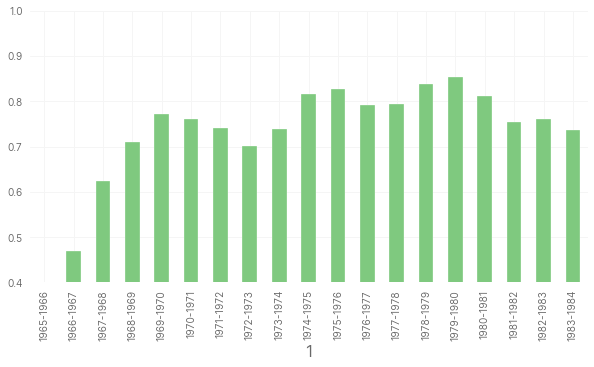

In [165]:
plot_similarity("bureaucracy_conservative","bureaucracy_labour",lf)
plt.ylim(0.4,1)

(0.4, 1.0)

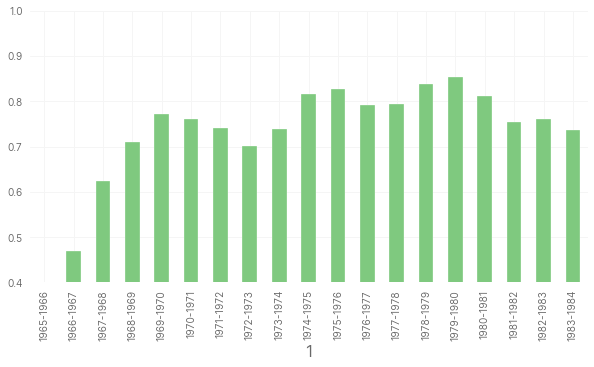

In [166]:
plot_similarity("bureaucracy_labour","bureaucracy_conservative",lf)
plt.ylim(0.4,1)

In [167]:
def GetNetwork(model, word):
    
    dft = pd.DataFrame()
    
    for wl1 in list(dict(model.most_similar(word, topn=5)).keys()):

        for wl2 in list(dict(model.most_similar(wl1, topn=5)).keys()):
            
            for wl3 in list(dict(model.most_similar(wl2, topn=5)).keys()):
                
                for wl4 in list(dict(model.most_similar(wl3, topn=5)).keys()):
                    source = wl3
                    target = wl4
                    t = pd.DataFrame([source, target]).T
                    dft = dft.append(t)
    
    dft.columns = ['source', 'target']
    dft['count'] = [model.wv.vocab[w].count for w in list(dft.target)]
    
    return dft

In [175]:
mo = KeyedVectors.load_word2vec_format('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/w2v-models/1967-1968-w24-model.bin',binary=True)
ndf = GetNetwork(mo,"bureaucracy_conservative").to_csv('test.csv',index=False)

In [196]:
def DistanceMatrix(word, model,n):
    list_words = [k for k,v in dict(model.most_similar(word,topn=n)).items()]
    
    list_words = [w for w in list_words if w in list(model.wv.vocab)]
    
    total_list = list()
    
    for word in list_words:
        
        list_word = list()
        
        for term in list_words:
            #tmp = model.distance(word, term)
            tmp = model.similarity(word, term)

            list_word.append(tmp)
        
        total_list.append(list_word)
    df = pd.DataFrame(total_list, columns = list_words, index = list_words)
    return df

In [205]:
d = DistanceMatrix("bureaucracy_conservative",mo,50)
freqs = {i:mo.wv.vocab[i].count for i in d.index}

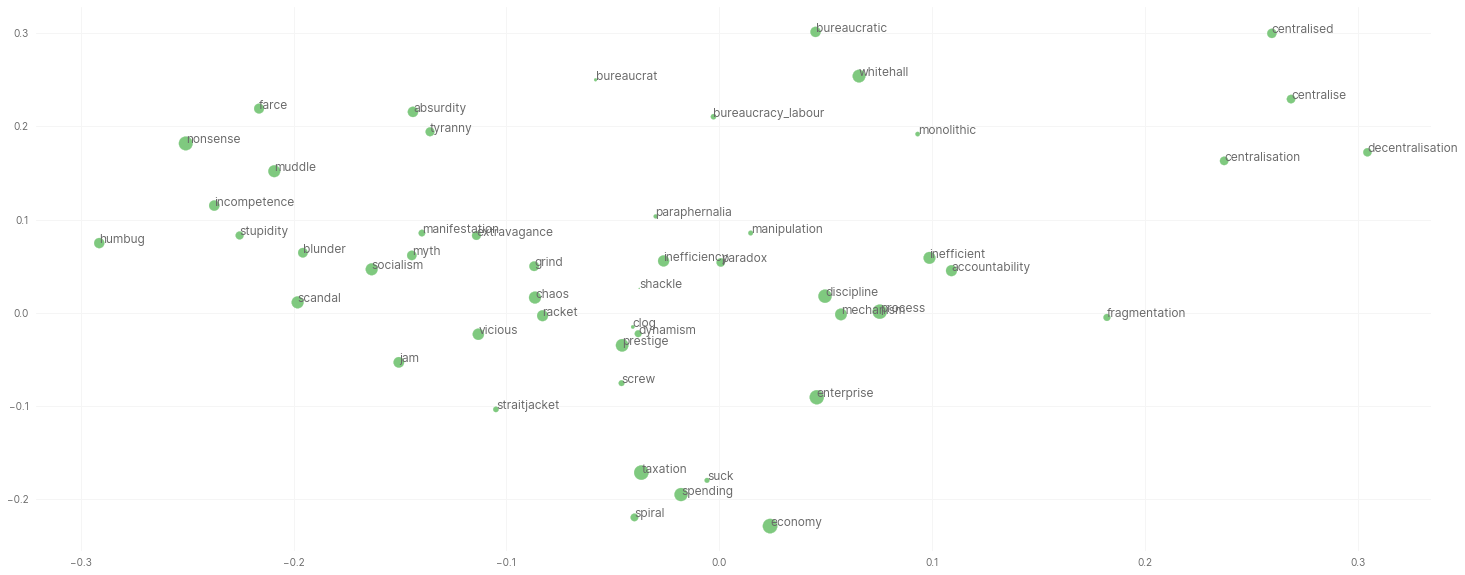

In [224]:
pca = PCA(n_components=2)
pca.fit(d)
pcadf = pd.DataFrame(pca.components_).T
pcadf.columns = ["p" + str(x) for x in pcadf.columns]
pcadf['size'] = [freqs[i] / 50 for i in d.index]
pcadf['label'] = d.index

fig, axes = plt.subplots(figsize=(25,10))

plt.scatter(x=pcadf['p0'],y=pcadf['p1'],s=pcadf['size'])

for i, txt in enumerate(pcadf['label']):
    axes.annotate(txt, (pcadf['p0'][i], pcadf['p1'][i]),fontsize=12)